# Chapter 02


In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

np.random.seed(0)

## P28 一標本t検定

対照実験を想定した関連2群のデータを生成してみる  
A:統制群 B:実験群と仮定  
A,B間には真の効果量dが存在するとする．同一個体から2条件分のデータを得ることを想定すると，サンプリングは次の2ステップで行われる  
A．個体の母平均をmu_aと置くと，各個体の統制条件でのデータはmu_a + 個体差として表される．個体差が分散var_aの正規分布に従うとすると，AのデータはN(mu_a, var_a)に従う  
B．条件Bのデータを 各個体の統制データA + 効果量d + ノイズ　として計算する．この時ノイズは確率変数で，実験の効果のばらつきを表す

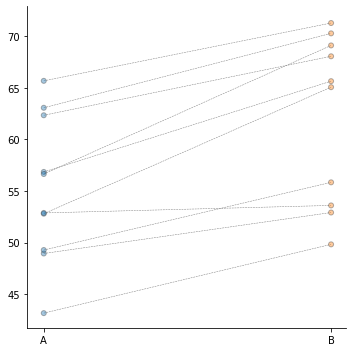

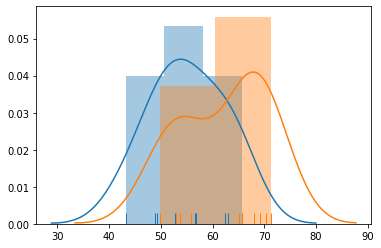

In [2]:
nsample = 10
d_true = 5

# Define params of cond A (= mean and variance of individuals)
mu_a, std_a = 50, 7
# Define params of cond B (= mean and variance of noise)
mu_b, std_b = 0, 5

# Step1
# Sample A from normal
xa = stats.norm.rvs(loc=mu_a, scale=std_a, size=(nsample,1))

# Step2
# Sample noise and calc B
noise = stats.norm.rvs(loc=mu_b, scale=std_b, size=(nsample,1))
xb = xa + d_true + noise

samples = pd.DataFrame(np.c_[xa, xb], columns=['A', 'B'])

# Plot paired strip
sns.catplot(data = samples, kind = 'strip', jitter=False, alpha=.40, linewidth = 1)
plt.plot([samples.iloc[:,0], samples.iloc[:,1]], color = 'grey', linewidth = 0.5, linestyle = '--')
plt.show()

# Plot histgram
sns.distplot(xa, norm_hist=True, kde=True, rug=True)
sns.distplot(xb, norm_hist=True, kde=True, rug=True)
plt.show()

上で作ったデータに対して，一標本t検定を行う

d_mean:-7.00, d_std:3.55
t-value:-6.24
p-value:0.00015145400930771657
Ttest_relResult(statistic=-6.239883170035028, pvalue=0.00015145400930775534)


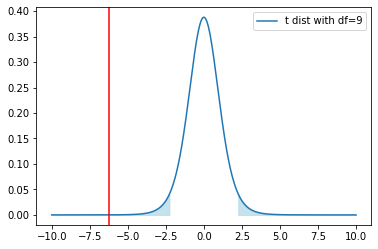

In [3]:
# Calc mean and unbiased std of d
d = samples['A'] - samples['B']
d_mean = d.mean()
d_std = d.std(ddof=1)

print('d_mean:' + format(d_mean,'.2f') + ', d_std:' + format(d_std,'.2f'))

# Calc t-value
n = len(d)
se = d_std / np.sqrt(n)
tval = d_mean / se

print('t-value:' + format(tval,'.2f'))

# Calc p-value
# p-val is cumulate area of t-distribution more right part than abs(tval)
pval_one = 1-stats.t.cdf(np.abs(tval), df=n-1)
# when calc two-side probability, left part is considered, so area is multiplied
pval_two = pval_one*2
# these are also calculated using sf (survival function)
# pval_one = stats.t.sf(np.abs(tval), df=n-1)

print('p-value:' + str(pval_two))

# Verify result using scipy
result = stats.ttest_rel(samples['A'], samples['B'])
print(result)

# Plot t-distribution with df=n-1 
x = np.linspace(-10, 10, 1000)
y = stats.t.pdf(x, df=n-1)
sns.lineplot(x,y, label='t dist with df='+str(n-1))

# Fill area with alpha=0.05 (two-side)
alpha = 0.05
lower_bound = stats.t.ppf(alpha/2, df=n-1)
Xlb = np.linspace(-10, lower_bound, 100)
Ylb = stats.t.pdf(Xlb, df=n-1)
plt.fill_between(Xlb, Ylb, color="lightblue", alpha=0.7)
upper_bound = stats.t.ppf(1-alpha/2, df=n-1)
Xub = np.linspace(upper_bound, 10, 100)
Yub = stats.t.pdf(Xub, df=n-1)
plt.fill_between(Xub, Yub, color="lightblue", alpha=0.7)

# Add vertical line of t-value
plt.axvline(x=tval, ymin=0, ymax=1, color='red') # add vertical line with x=z
plt.show()